In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.random.seed(167)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #elif 'datetime' not in col_type.name:
        #    df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 1. Load data and Features engineering

In [3]:
train = pd.read_csv('train_v2.csv')

In [4]:
test = pd.read_csv('sample_submission_v2.csv')

In [5]:
msno_train = train['msno'].tolist()
msno_test = test['msno'].tolist()
msno_all = list(set(msno_train).union(set(msno_test)))
msno_inter = list(set(msno_train).intersection(set(msno_test)))

### 1.1. `user_logs` dataset

In [6]:
def user_preprocess(df):
    df = df.loc[df['msno'].isin(msno_all)]
    df = reduce_mem_usage(df)
    df = df.groupby('msno').agg({'msno': 'count',
                                 'date': 'min',
                                 'num_25': 'sum',
                                 'num_50': 'sum',
                                 'num_75': 'sum',
                                 'num_985': 'sum',
                                 'num_100': 'sum',
                                 'num_unq': 'sum', 
                                 'total_secs': 'sum'})
    df = df.rename(columns = {'msno': 'count'}).reset_index()  
    return df

In [7]:
reader = pd.read_csv('user_logs.csv', chunksize=40000000)
user_data = pd.DataFrame()
for chunk in tqdm(reader):
    chunk = user_preprocess(chunk)
    user_data = pd.concat([user_data, chunk])
del chunk

0it [00:00, ?it/s]D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [8]:
user_logs = pd.read_csv('user_logs_v2.csv')
user_logs = user_preprocess(user_logs)
user_data = pd.concat([user_data, user_logs])
del user_logs

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [9]:
user_data = user_data.groupby('msno').agg({'count': 'sum',
                                           'date': 'min',
                                           'num_25': 'sum',
                                           'num_50': 'sum',
                                           'num_75': 'sum',
                                           'num_985': 'sum',
                                           'num_100': 'sum',
                                           'num_unq': 'sum', 
                                           'total_secs': 'sum'})

In [10]:
user_data = user_data.reset_index()
user_data['date'] = pd.to_datetime(user_data['date'], format='%Y%m%d')
user_data['year_start'] = user_data['date'].dt.year
user_data = user_data.drop('date', axis = 1)

In [11]:
cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
for col in cols:
    user_data[col] = user_data[col]/user_data['count']

In [12]:
train = pd.merge(train, user_data, on = 'msno', how = 'left')
test = pd.merge(test, user_data, on = 'msno', how = 'left')

In [13]:
del user_data

### 1.2. `members_v3.csv` dataset

In [14]:
members = pd.read_csv('members_v3.csv')
members = members.loc[members['msno'].isin(msno_all)] 
train = pd.merge(train, members, how = 'left', on = 'msno')
test = pd.merge(test, members, how = 'left', on = 'msno')
del members

In [15]:
def members_preprocess(df):
    df['city'] = df['city'].fillna(0)
    df['city'] = df['city'].apply(lambda x: 1 if ((x == 0) | (x == 1)) else 0)
    df['gender'] = df['gender'].fillna('unknown')
    df['registered_via'] = df['registered_via'].fillna(0)
    df['registered_via'] = df['registered_via'].apply(lambda x: 0 if ((x == 0) | (x == 7)) else (2 if x == 4 else 1))
    df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d')
    df['registration_year'] = df['registration_init_time'].dt.year
    df = df.drop(['bd', 'registration_init_time'], axis = 1)
    return df

In [16]:
train = members_preprocess(train)
test = members_preprocess(test)

### 1.3. `transactions.csv` and `transactions_v2.csv` dataset

In [17]:
transactions = pd.concat([pd.read_csv('transactions.csv'), pd.read_csv('transactions_v2.csv')], axis = 0)
transactions = reduce_mem_usage(transactions)
transactions = transactions.loc[transactions['msno'].isin(msno_all)] 
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
transactions = transactions.sort_values(by = ['msno', 'transaction_date'], ascending = [True, True])
train_transactions = transactions.loc[transactions['msno'].isin(msno_train)]
test_transactions = transactions.loc[transactions['msno'].isin(msno_test)]
del transactions

In [18]:
def transaction_features(transactions, df, is_train = True):
    check1 = transactions.groupby('msno')['transaction_date', 'membership_expire_date', 'is_cancel'].nth(-1)
    if is_train == True:
        check2 = transactions.loc[transactions['membership_expire_date'] <= pd.Timestamp('2017-03-31'), ['msno', 'transaction_date', 'membership_expire_date', 'is_cancel']]
    else:
        check2 = transactions.loc[transactions['membership_expire_date'] <= pd.Timestamp('2017-04-30'), ['msno', 'transaction_date', 'membership_expire_date', 'is_cancel']]
    check3 = check2.groupby('msno')['membership_expire_date'].max()
    check4 = check1.loc[check1['membership_expire_date'] != check3]
    check5 = check1.loc[check1['membership_expire_date'] == check3]
    case2 = check5.loc[check5['is_cancel'] == 0].index.tolist()
    case3 = check4.loc[(check4['transaction_date'] < check3.loc[check4.index]) & (check4['is_cancel'] == 0)].index.tolist()
    case4 = check4.loc[(check4['transaction_date'] >= check3.loc[check4.index]) & (check4['is_cancel'] == 0)].index.tolist()
    del check1, check2, check3, check4, check5
    df['transaction_proba'] = 0.85
    df.loc[df['msno'].isin(case2), 'transaction_proba'] = 0.6
    df.loc[df['msno'].isin(case3), 'transaction_proba'] = 0.25
    df.loc[train['msno'].isin(case4), 'transaction_proba'] = 0.02
    return df

In [19]:
train = transaction_features(train_transactions, train, is_train = True)
test = transaction_features(test_transactions, test, is_train = False)

In [20]:
def transactions_preprocess(transactions, df):
    transactions['membership_duration'] = ((transactions['membership_expire_date'] - transactions['transaction_date'])/np.timedelta64(1, 'D')).astype(int)
    transactions.loc[transactions['membership_duration'] < 0, 'membership_duration'] = 0
    transactions['discount'] = (transactions['plan_list_price'] - transactions['actual_amount_paid']).apply(lambda x: 1 if x > 0 else 0)
    transactions['time_interrupt'] = transactions.groupby('msno')['transaction_date'].diff()/np.timedelta64(1, 'D')
    sum_up = transactions.groupby('msno').agg({'payment_method_id': lambda x: x.mode().iloc[0], 
                                               'payment_plan_days': np.median,
                                               'is_cancel': np.max,
                                               'discount': np.max,
                                               'actual_amount_paid': np.mean, 
                                               'membership_duration': lambda x: x.mode().iloc[0],
                                               'time_interrupt': np.median,
                                               'transaction_date': 'first'})
    sum_up['time_interrupt'] = sum_up['time_interrupt'].fillna(0)
    sum_up['payment_method_id'] = sum_up['payment_method_id'].apply(lambda x: 1 if x == 41 else 0)
    sum_up['transaction_date'] = sum_up['transaction_date'].dt.year
    df = pd.merge(df, sum_up.reset_index(), on = 'msno')
    del transactions, sum_up
    return reduce_mem_usage(df)

In [21]:
train = transactions_preprocess(train_transactions, train)
test = transactions_preprocess(test_transactions, test)

In [22]:
del train_transactions, test_transactions

In [23]:
train.loc[train['registration_year'].isnull(), 'registration_year'] = train.loc[train['registration_year'].isnull(), 'transaction_date']
train.loc[train['year_start'].isnull(), 'year_start'] = train.loc[train['year_start'].isnull(), 'transaction_date']

In [24]:
test.loc[test['registration_year'].isnull(), 'registration_year'] = test.loc[test['registration_year'].isnull(), 'transaction_date']
test.loc[test['year_start'].isnull(), 'year_start'] = test.loc[test['year_start'].isnull(), 'transaction_date']

In [25]:
def imputer(df):
    nb_null = df.isnull().any(axis=1).sum()
    idx = np.random.permutation(df.loc[~df.isnull().any(axis = 1)].index)[:nb_null]
    df.loc[df.isnull().any(axis = 1)] = df.loc[idx].values
    return df

In [26]:
cols = ['count', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
train.loc[:, cols] = imputer(train.loc[:, cols])
test.loc[:, cols] = imputer(test.loc[:, cols])

In [27]:
cols = ['count', 'year_start', 'registration_year', 'payment_plan_days', 'time_interrupt']
train[cols] = train[cols].astype(int)
test[cols] = test[cols].astype(int)

In [28]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [29]:
train.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registration_year,transaction_proba,payment_method_id,payment_plan_days,is_cancel,discount,actual_amount_paid,membership_duration,time_interrupt,transaction_date
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,64,8.640625,1.671875,0.890625,1.437500,31.734375,12.156250,7513.968262,...,2013,0.600098,0,0,1,0,149.000,30,31,2015
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,80,1.837891,0.562500,0.287598,0.312500,10.101562,9.164062,2712.790527,...,2013,0.250000,0,30,0,0,134.500,30,34,2016
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,342,31.531250,2.283203,1.237305,1.231445,19.546875,44.718750,5648.679688,...,2013,0.020004,0,30,0,0,149.125,30,32,2015
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,136,5.093750,1.573242,0.786621,0.646973,10.765625,17.484375,3538.294922,...,2014,0.850098,1,30,1,0,143.875,0,8,2015
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,271,1.169922,0.715820,0.439209,0.276855,14.953125,14.414062,3874.755615,...,2014,0.020004,1,30,1,0,117.125,186,30,2015


In [30]:
test.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registration_year,transaction_proba,payment_method_id,payment_plan_days,is_cancel,discount,actual_amount_paid,membership_duration,time_interrupt,transaction_date
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,4,2.000000,0.500000,0.250000,0.000000,0.250000,3.000000,2.079830e+02,...,2015,0.600098,1,30,0,0,99.0,31,31,2015
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,815,21.703125,4.398438,3.111328,3.269531,47.718750,68.812500,-1.131702e+13,...,2005,0.600098,0,30,0,0,149.0,31,31,2015
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,77,5.089844,1.103516,0.519531,0.480469,16.968750,17.421875,4.419593e+03,...,2014,0.600098,1,30,1,1,91.0,31,30,2015
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,139,9.765625,1.410156,0.834473,0.726562,11.015625,17.875000,3.233542e+03,...,2015,0.600098,1,30,0,0,99.0,31,31,2015
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,16,0.750000,0.437500,0.250000,0.187500,23.000000,23.625000,5.941232e+03,...,2016,0.600098,0,30,0,0,129.0,30,31,2016


In [31]:
cols_dummies = ['city', 'gender', 'registered_via', 'payment_method_id', 'is_cancel', 'discount']

In [32]:
train_dummies = pd.get_dummies(train[cols_dummies].astype(str))
test_dummies = pd.get_dummies(test[cols_dummies].astype(str))

In [33]:
train = train.drop(cols_dummies, axis = 1)
test = test.drop(cols_dummies, axis = 1)

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train.iloc[:, 2:])
train.iloc[:, 2:] = scaler.transform(train.iloc[:, 2:])
test.iloc[:, 2:] = scaler.transform(test.iloc[:, 2:])

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int16, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [35]:
train = pd.concat([train, train_dummies], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## 2. Model selection

In [79]:
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')

In [80]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [8]:
train.head()

,msno,is_churn,count,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,gender_unknown,registered_via_0,registered_via_1,registered_via_2,payment_method_id_0,payment_method_id_1,is_cancel_0,is_cancel_1,discount_0,discount_1
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0.076843,0.005672,0.014168,0.010010,0.012222,0.047607,0.007957,0.973633,...,0,0,1,0,1,0,0,1,1,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,0.096313,0.001206,0.004768,0.003231,0.002657,0.015160,0.005825,0.973633,...,0,0,1,0,1,0,1,0,1,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,0.415771,0.020706,0.019348,0.013901,0.010468,0.029327,0.031189,0.973633,...,0,0,1,0,1,0,1,0,1,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0.164673,0.003345,0.013336,0.008835,0.005501,0.016159,0.011757,0.973633,...,1,1,0,0,0,1,0,1,1,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0.329346,0.000768,0.006065,0.004936,0.002354,0.022430,0.009567,0.973633,...,0,1,0,0,0,1,0,1,1,0


In [5]:
train['dataset'] = 1
test['dataset'] = 0

In [6]:
combine = pd.concat([train, test], axis = 0)

In [7]:
X = combine.iloc[:, 2:-1]
Y = combine['dataset']

In [10]:
clf = LogisticRegression()
clf.fit(X, Y)
Y_pred = clf.predict(X)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [11]:
idx_val = np.where(Y - Y_pred == 1)[0]

In [12]:
X_val = train.iloc[idx_val, 2:-1]
X_train = train.iloc[~train.index.isin(idx_val), 2:-1]
Y_val = train.loc[idx_val, 'is_churn']
Y_train = train.loc[~train.index.isin(idx_val), 'is_churn']
X_test = test.iloc[:, 2:-1]

In [111]:
X_dev = train.iloc[:, 2:]
Y_dev = train['is_churn']

In [146]:
X = train.iloc[:, 2:]
Y = train['is_churn']
X_test = test.iloc[:, 2:]

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 70000, random_state = 167)

### 2.1. Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

In [41]:
params_C = [1, 10, 20, 40, 60, 80, 100]

In [42]:
res = []
for c in params_C:
    clf = LogisticRegression(C = c)
    clf.fit(X_train, Y_train)
    res.append(log_loss(Y_val, clf.predict_proba(X_val)))

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futu

In [43]:
res

[1.314350873714348,
 1.3582844112050405,
 1.3628964102714622,
 1.3650793444835887,
 1.3664276531035353,
 1.3671052247348037,
 1.366248607304074]

In [44]:
clf = LogisticRegression(C = 1)
clf.fit(X_train, Y_train)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [57]:
params = {'C': [1, 10, 20, 50, 80, 100, 200, 500]}
clf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, scoring = 'neg_log_loss')
clf.fit(X, Y)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to '

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 20, 50, 80, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [58]:
clf.best_params_

{'C': 80}

In [59]:
clf.best_score_

-0.13432309474886434

In [60]:
clf.score(X, Y)

-0.1342809992858557

In [45]:
Y_test = clf.predict_proba(X_test)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [46]:
Y_test = clf.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('logistic2.csv', index = False)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


### 2.2. Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [72]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1200, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [None, 5, 10],
               'min_samples_leaf': [5, 10]}

In [ ]:
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=167, n_jobs = -1)

# Fit the random search model
clf_random.fit(X, Y)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [56]:
params_max_depth = [3, 6, 10, 20]

In [ ]:
res = []
for c in params_max_depth:
    clf = RandomForestClassifier(n_estimators = 100, max_depth = c, min_samples_leaf = 10)
    clf.fit(X_train, Y_train)
    res.append(log_loss(Y_val, clf.predict_proba(X_val)))

In [151]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_leaf = 10)

In [152]:
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [153]:
Y_train_pred = clf.predict_proba(X_train)
Y_val_pred = clf.predict_proba(X_val)

In [154]:
log_loss(Y_train, Y_train_pred)

0.13043583228816008

In [155]:
log_loss(Y_val, Y_val_pred)

0.12801750398547512

In [156]:
Y_test = clf.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('randomforest5.csv', index = False)

In [112]:
Y_dev_rf = clf.predict_proba(X_dev)

### 2.3. KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
clf = KNeighborsClassifier(n_neighbors = 10, weights = 'distance')

In [50]:
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='distance')

In [52]:
Y_train_pred = clf.predict_proba(X_train)
Y_val_pred = clf.predict_proba(X_val)

In [53]:
log_loss(Y_train, Y_train_pred)

9.99200722162641e-16

In [54]:
log_loss(Y_val, Y_val_pred)

0.3804673961467252

In [55]:
Y_test = clf.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('knn1.csv', index = False)

In [58]:
train.to_csv('train_processed.csv', index = False)
test.to_csv('test_processed.csv', index = False)

### 2.4. SVM

In [51]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(C = 20, kernel = 'rbf', probability = True)
clf.fit(X_train, Y_train)

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 2.5. Catboost

In [92]:
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool

In [19]:
scores = []
for i in range(10):
    my_random_seed = i*42 + 2013
    model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=my_random_seed, loss_function='CrossEntropy', custom_loss = 'Logloss')
    model.fit(X_train, Y_train, eval_set=(X_val, Y_val), verbose=False)
    yhat_validation = model.predict_proba(X_val)
    scores.append(log_loss(Y_val, yhat_validation))

In [113]:
cb = CatBoostClassifier(iterations=150, learning_rate=0.1, od_type='Iter', od_wait=50, loss_function='CrossEntropy', custom_loss = 'Logloss', random_seed = 167)
cb.fit(X_train, Y_train, eval_set=(X_val, Y_val), verbose=50)

0:	learn: 0.4653355	test: 0.4658335	best: 0.4658335 (0)	total: 401ms	remaining: 59.8s


Training has stopped (degenerate solution on iteration 11, probably too small l2-regularization, try to increase it)



bestTest = 0.08504825676
bestIteration = 10

Shrink model to first 11 iterations.


In [94]:
Y_train_pred = cb.predict_proba(X_train)
Y_val_pred = cb.predict_proba(X_val)

In [95]:
log_loss(Y_train, Y_train_pred)

0.08523476631178266

In [96]:
log_loss(Y_val, Y_val_pred)

0.0850482567621041

In [53]:
cb.get_feature_importance(Pool(X_train, Y_train))

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 48.26674261652575,
 2.8797069280101284,
 0.0,
 45.04158502190335,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.811965433560769,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [97]:
Y_test = model.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('cb3.csv', index = False)

In [114]:
Y_dev_cb = cb.predict_proba(X_dev)

### 2.6. XGBoost

In [98]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [99]:
xgb1 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 150,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [100]:
xgb1.fit(X_train, Y_train, eval_metric = 'logloss', eval_set = [(X_val, Y_val)], early_stopping_rounds = 50, verbose = 50)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [ ]:
xgb1.evals_result()

In [101]:
Y_train_pred = xgb1.predict_proba(X_train)
Y_val_pred = xgb1.predict_proba(X_val)

In [102]:
log_loss(Y_train, Y_train_pred)

0.06598820278000116

In [103]:
log_loss(Y_val, Y_val_pred)

0.06582322741244472

In [104]:
Y_test = xgb1.predict_proba(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('xgb2.csv', index = False)

In [115]:
Y_dev_xgb = xgb1.predict_proba(X_dev)

In [58]:
xgb1.feature_importances_

array([0.05197452, 0.03541401, 0.03210191, 0.02980892, 0.02598726,
       0.03617834, 0.03490446, 0.00178344, 0.00738853, 0.02980892,
       0.03847134, 0.04484076, 0.21426752, 0.14343949, 0.12050956,
       0.02242038, 0.02012739, 0.00152866, 0.00229299, 0.00152866,
       0.00509554, 0.00917197, 0.00203822, 0.00254777, 0.0155414 ,
       0.00407643, 0.03796178, 0.00611465, 0.01936306, 0.0033121 ],
      dtype=float32)

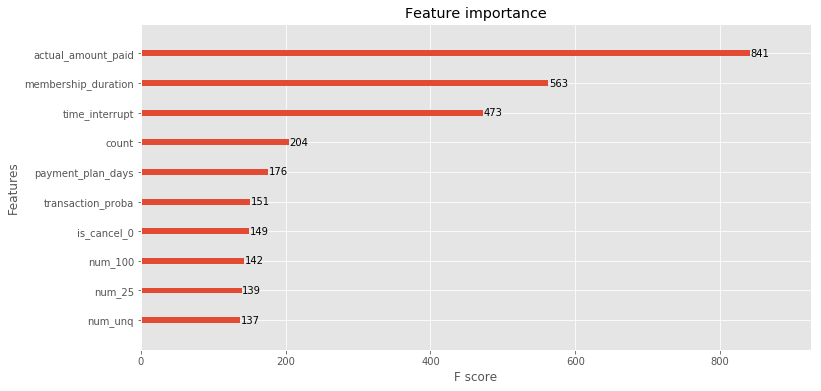

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb1, max_num_features=10, ax = ax)

### 2.7. Neural Network

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [106]:
model = Sequential()
model.add(Dense(50, activation = 'relu', input_shape = (30, )))
model.add(Dropout(0.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(80, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [107]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [108]:
model.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_val, Y_val), verbose = 2)

Train on 1808431 samples, validate on 70000 samples
Epoch 1/10
 - 34s - loss: 0.0899 - acc: 0.9711 - val_loss: 0.0776 - val_acc: 0.9749
Epoch 2/10
 - 36s - loss: 0.0817 - acc: 0.9743 - val_loss: 0.0778 - val_acc: 0.9749
Epoch 3/10
 - 34s - loss: 0.0807 - acc: 0.9743 - val_loss: 0.0766 - val_acc: 0.9749
Epoch 4/10
 - 34s - loss: 0.0799 - acc: 0.9743 - val_loss: 0.0764 - val_acc: 0.9749
Epoch 5/10
 - 33s - loss: 0.0795 - acc: 0.9743 - val_loss: 0.0768 - val_acc: 0.9749
Epoch 6/10
 - 36s - loss: 0.0791 - acc: 0.9744 - val_loss: 0.0768 - val_acc: 0.9749
Epoch 7/10
 - 33s - loss: 0.0790 - acc: 0.9743 - val_loss: 0.0760 - val_acc: 0.9749
Epoch 8/10
 - 34s - loss: 0.0787 - acc: 0.9743 - val_loss: 0.0747 - val_acc: 0.9749
Epoch 9/10
 - 35s - loss: 0.0785 - acc: 0.9743 - val_loss: 0.0753 - val_acc: 0.9749
Epoch 10/10
 - 34s - loss: 0.0785 - acc: 0.9744 - val_loss: 0.0748 - val_acc: 0.9749


In [109]:
Y_test = model.predict(X_test)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test.ravel()})
submission.to_csv('nn3.csv', index = False)

In [116]:
Y_dev_nn = model.predict(X_dev)

In [128]:
X_train_stack = np.c_[Y_dev_rf[:, 1], Y_dev_cb[:, 1], Y_dev_xgb[:, 1], Y_dev_nn[:, 0]]

In [130]:
rf = pd.read_csv('randomforest4.csv')
cb = pd.read_csv('cb3.csv')
xgb = pd.read_csv('xgb2.csv')
nn = pd.read_csv('nn3.csv')

In [135]:
X_test_stack = pd.concat([rf['is_churn'], cb['is_churn'], xgb['is_churn'], nn['is_churn']], axis = 1).values

In [139]:
xgb_stack = XGBClassifier(
 learning_rate = 0.1,
 n_estimators = 150,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [143]:
xgb_stack.fit(X_train_stack, train['is_churn'].values, eval_metric = 'logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=150,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [144]:
log_loss(train['is_churn'].values, xgb_stack.predict_proba(X_train_stack))

0.09904359886565087

In [145]:
Y_test = xgb_stack.predict_proba(X_test_stack)
submission = pd.DataFrame({'msno': test['msno'], 'is_churn': Y_test[:, 1].ravel()})
submission.to_csv('xgb3.csv', index = False)